In [2]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn as nn

In [80]:
from scipy.optimize import curve_fit

In [87]:
import pandas as pd

## Fitting an exponential 

It turns out that Neural Networks with at least one hidden layer are universal approximators. That is, it can be shown that given any continuous function f(x)
and some ϵ>0, there exists a Neural Network g(x)
with one hidden layer (with a reasonable choice of non-linearity, e.g. sigmoid) such that ∀x,∣f(x)−g(x)∣<ϵ
In other words, the neural network can approximate any continuous function.



### Generate data

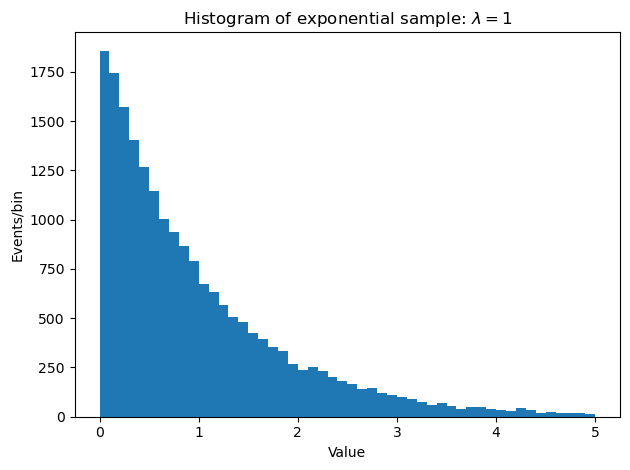

In [4]:

rng = np.random.default_rng(19680801)
ll = 1.0
scale = 1/ll
x = rng.exponential(scale=scale, size=20000)

num_bins = 50
fig, ax = plt.subplots()

# the histogram of the data
yb, bins, patches = ax.hist(x, num_bins, (0,5), density=False)

# take the x's as bin centers
xb = [np.mean([bins[i],bins[i+1]]) for i in range(0, len(bins)-1)]

# add a 'best fit' line

#ax.plot(xb, xnn, '--')
ax.set_xlabel('Value')
ax.set_ylabel('Events/bin')
ax.set_title('Histogram of exponential sample: '
             fr'$\lambda={ll:.0f}$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

### Definition of the NN

We use a NN that takes as input the center of the bins (dim 50) and maps it to the output (e.g ypred) through one hidden layer. The loss function is define as the MSE minimazing the Euclidean distance between ypred and the observations yb. 

### PyTorch allows to use the Mac GPU (mps)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [7]:
xx = torch.tensor(xb, device=device, dtype=torch.float)
yy = torch.tensor(yb, device=device, dtype=torch.float)
ypred = torch.zeros(yb.size, device=device, dtype=torch.float)

#### Define the NN

In [8]:
class LNN(nn.Module):
    def __init__(self):
        super(LNN, self).__init__()
    
        self.net = torch.nn.Sequential(
                                    torch.nn.Linear(50, 50), 
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(50, 50), 
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(50, 50),)
    def forward(self, x):
        return self.net(x)

In [9]:
# Load the model.
model = LNN().to(device)
print(model)

LNN(
  (net): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
  )
)


In [10]:
model(xx)

tensor([-2.0946e-01, -1.2804e-01,  1.5187e-01,  5.0183e-02,  2.6340e-01,
        -3.9578e-01, -3.4509e-01, -3.9511e-02,  1.3613e-01, -9.0410e-02,
        -3.4375e-01, -7.9360e-02,  9.4698e-03, -1.1785e-01, -3.3456e-01,
        -4.6445e-02,  1.9000e-01,  1.5965e-01, -3.1299e-01, -7.1508e-02,
         2.5535e-01,  2.5155e-03, -4.4754e-02,  2.3993e-01,  6.5931e-02,
        -4.8943e-02,  2.1540e-01,  1.0982e-01,  1.7590e-01, -9.5164e-02,
         1.3019e-01, -3.2800e-03, -7.1331e-02,  2.8474e-01, -5.0364e-01,
         5.8830e-01, -3.7387e-01,  2.2975e-01,  3.4343e-01, -7.2090e-02,
        -5.8175e-02, -7.3639e-02,  3.6226e-01, -2.2133e-04,  4.1202e-01,
         2.0072e-01, -3.7173e-02, -2.1721e-01,  2.5500e-01, -2.4218e-02],
       device='mps:0', grad_fn=<LinearBackward0>)

In [13]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
loss_fn(model(xx), yy)

tensor(19803568., device='mps:0', grad_fn=<MseLossBackward0>)

#### Train the network

In [15]:
# Training loop
epochs = 1000
train_losses = []
for epoch in range(epochs):

    #print(f"\nEPOCH {epoch}")

    model.train()
    y_pred = model(xx)
    loss = loss_fn(y_pred, yy)
   
    if epoch % 100 == 0:
        print(f"epoch   ->{epoch}")
        #print(f"y_pred  ->{y_pred}")
        #print(f"yy_pred ->{yy}")
        print(f"Loss    ->{loss.item()}")
    train_losses.append(loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. 
    loss.backward()

    # Update the weights using gradient descent.
    optimizer.step()


epoch   ->0
Loss    ->19803568.0
epoch   ->100
Loss    ->15908752.0
epoch   ->200
Loss    ->2292878.0
epoch   ->300
Loss    ->110195.375
epoch   ->400
Loss    ->4482.90283203125
epoch   ->500
Loss    ->100.25257873535156
epoch   ->600
Loss    ->1.248159408569336
epoch   ->700
Loss    ->0.015074721537530422
epoch   ->800
Loss    ->0.00011148279008921236
epoch   ->900
Loss    ->3.8839527405798435e-05


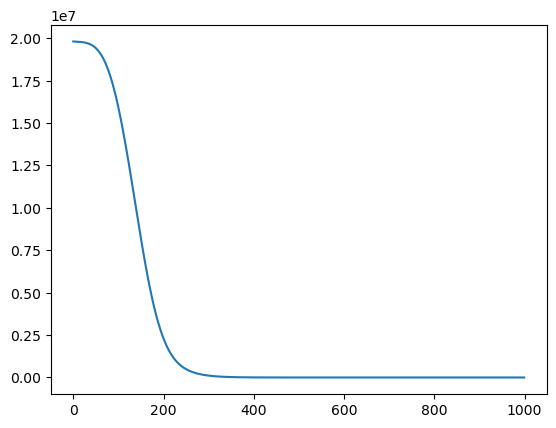

In [16]:
plt.plot(train_losses)

In [17]:
xnn = model(xx).cpu().detach().numpy()

In [19]:
xnn

array([1858.0017  , 1742.9976  , 1571.0005  , 1403.0004  , 1265.0004  ,
       1144.0001  , 1005.0001  ,  937.00006 ,  865.00006 ,  790.      ,
        675.00006 ,  635.      ,  568.      ,  507.      ,  479.99997 ,
        426.      ,  396.      ,  353.00003 ,  333.      ,  267.      ,
        236.00002 ,  252.      ,  234.      ,  201.      ,  181.      ,
        167.      ,  141.      ,  145.      ,  119.      ,  109.      ,
         99.      ,   88.      ,   76.      ,   57.      ,   71.      ,
         55.      ,   39.      ,   46.999996,   47.999996,   39.      ,
         33.      ,   31.000004,   46.      ,   31.999996,   16.999998,
         24.000002,   19.999998,   19.000044,   17.000008,   15.980928],
      dtype=float32)

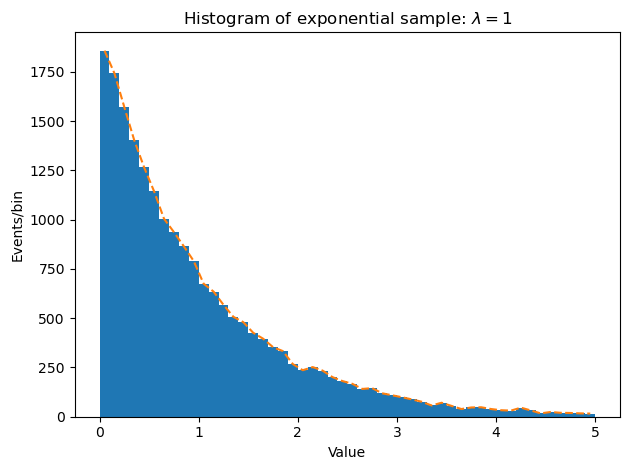

In [22]:
fig, ax = plt.subplots()
_, _, patches = ax.hist(x, num_bins, (0,5), density=False)

ax.plot(xb, xnn, '--')
ax.set_xlabel('Value')
ax.set_ylabel('Events/bin')
ax.set_title('Histogram of exponential sample: '
             fr'$\lambda={ll:.0f}$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

## Minimize the parameters of the model 

In [27]:
def exp_cte(x, a, b, c):
    return a + b*np.exp(-c*x)

In [66]:
a0 = 0.0
b0 = yb[0]
c0 = (1/xb[1]) * (1- (yb[1] - a0)/b0)
print(f"a0 ->{a0:.2f} b0 ->{b0:.2f} c0->{c0:.2f}")

a0 ->0.00 b0 ->1858.00 c0->0.41


In [67]:
a = torch.tensor(a0, device=device, dtype=torch.float, requires_grad=True)
b = torch.tensor(b0, device=device, dtype=torch.float, requires_grad=True)
c = torch.tensor(c0, device=device, dtype=torch.float, requires_grad=True)

In [68]:
y_pred = a + b * torch.exp(-c*xx)

In [69]:
# y = a + b*exp(c*x)
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
#a = torch.randn((), device=device, dtype=torch.float, requires_grad=True)
#b = torch.randn((), device=device, dtype=torch.float, requires_grad=True)
#c = torch.randn((), device=device, dtype=torch.float, requires_grad=True)
a = torch.tensor(a0, device=device, dtype=torch.float, requires_grad=True)
b = torch.tensor(b0, device=device, dtype=torch.float, requires_grad=True)
c = torch.tensor(c0, device=device, dtype=torch.float, requires_grad=True)
L = []
nepochs = 1000
learning_rate = 5e-6
for t in range(nepochs):
    # Forward pass: compute predicted y
    y_pred = a + b * torch.exp(-c*xx)

    # Compute and print loss
    loss = (y_pred - yy).pow(2).sum() 
    L.append(loss.item()) 

    if t % 100 == 0:
        print(f"epoch   ->{t}")
        print(f"a  ->{a:.2f} b ->{b:.2f} c->{c:.2f}")
        #print(f"yy_pred ->{yy}")
        print(f"Loss    ->{loss.item()}")
    L.append(loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        if t % 100 == 0:
            print(f"a.grad  ->{a.grad:.4f} b.grad ->{b.grad:.4f} c.grad->{c.grad:.4f}")
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad

        # Manually zero the gradients after updating weights
        #a.grad = None
        b.grad = None
        c.grad = None
        #d.grad = None

epoch   ->0
a  ->0.00 b ->1858.00 c->0.41
Loss    ->8538550.0
a.grad  ->38848.9180 b.grad ->16082.5488 c.grad->-55783432.0000
epoch   ->100
a  ->19.02 b ->1857.92 c->279.33
Loss    ->19063228.0
a.grad  ->-37857.8125 b.grad ->-0.0032 c.grad->0.2938
epoch   ->200
a  ->37.49 b ->1857.92 c->279.33
Loss    ->18381124.0
a.grad  ->-36011.0117 b.grad ->-0.0031 c.grad->0.2908
epoch   ->300
a  ->55.06 b ->1857.92 c->279.33
Loss    ->17763948.0
a.grad  ->-34254.3086 b.grad ->-0.0031 c.grad->0.2880
epoch   ->400
a  ->71.77 b ->1857.92 c->279.33
Loss    ->17205516.0
a.grad  ->-32583.2969 b.grad ->-0.0031 c.grad->0.2854
epoch   ->500
a  ->87.66 b ->1857.92 c->279.33
Loss    ->16700238.0
a.grad  ->-30993.8008 b.grad ->-0.0030 c.grad->0.2828
epoch   ->600
a  ->102.78 b ->1857.92 c->279.33
Loss    ->16243056.0
a.grad  ->-29481.8477 b.grad ->-0.0030 c.grad->0.2804
epoch   ->700
a  ->117.16 b ->1857.92 c->279.33
Loss    ->15829392.0
a.grad  ->-28043.6504 b.grad ->-0.0030 c.grad->0.2781
epoch   ->800
a  -

In [71]:
a0 = 0
a = torch.tensor(a0, device=device, dtype=torch.float, requires_grad=True)
b = torch.tensor(b0, device=device, dtype=torch.float, requires_grad=True)
c = torch.tensor(c0, device=device, dtype=torch.float, requires_grad=True)
L = []
nepochs = 1000
learning_rate = 5e-7
for t in range(nepochs):
    # Forward pass: compute predicted y
    y_pred = a + b * torch.exp(-c*xx)

    # Compute and print loss
    loss = (y_pred - yy).pow(2).sum() 
    L.append(loss.item()) 

    if t % 100 == 0:
        print(f"epoch   ->{t}")
        print(f"a  ->{a:.2f} b ->{b:.2f} c->{c:.2f}")
        print(f"Loss    ->{loss.item()}")
    L.append(loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        if t % 100 == 0:
            print(f"b.grad ->{b.grad:.4f} c.grad->{c.grad:.4f}")
        #a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad

        # Manually zero the gradients after updating weights
        #a.grad = None
        b.grad = None
        c.grad = None

epoch   ->0
a  ->0.00 b ->1858.00 c->0.41
Loss    ->8538550.0
b.grad ->16082.5488 c.grad->-55783432.0000
epoch   ->100
a  ->0.00 b ->1858.03 c->23.88
Loss    ->17832808.0
b.grad ->-887.5295 c.grad->103315.3281
epoch   ->200
a  ->0.00 b ->1858.08 c->17.37
Loss    ->16963176.0
b.grad ->-1189.9751 c.grad->174088.0000
epoch   ->300
a  ->0.00 b ->1849.75 c->66062.42
Loss    ->19801452.0
b.grad ->0.0000 c.grad->-0.0000
epoch   ->400
a  ->0.00 b ->1849.75 c->66062.42
Loss    ->19801452.0
b.grad ->0.0000 c.grad->-0.0000
epoch   ->500
a  ->0.00 b ->1849.75 c->66062.42
Loss    ->19801452.0
b.grad ->0.0000 c.grad->-0.0000
epoch   ->600
a  ->0.00 b ->1849.75 c->66062.42
Loss    ->19801452.0
b.grad ->0.0000 c.grad->-0.0000
epoch   ->700
a  ->0.00 b ->1849.75 c->66062.42
Loss    ->19801452.0
b.grad ->0.0000 c.grad->-0.0000
epoch   ->800
a  ->0.00 b ->1849.75 c->66062.42
Loss    ->19801452.0
b.grad ->0.0000 c.grad->-0.0000
epoch   ->900
a  ->0.00 b ->1849.75 c->66062.42
Loss    ->19801452.0
b.grad ->

## Fiting a double exponential 

In [76]:
def exp2(x, a, b, c, d):
    return a * np.exp(-b * x) + c * np.exp(-d * x)


In [77]:
a = 2.5
b = 1.3
c = 0.5
d = 0.5
x = np.linspace(0,4,50) # Example data
y = exp2(x, 2.5, 1.3, 0.5, 0.5) # Example exponential data

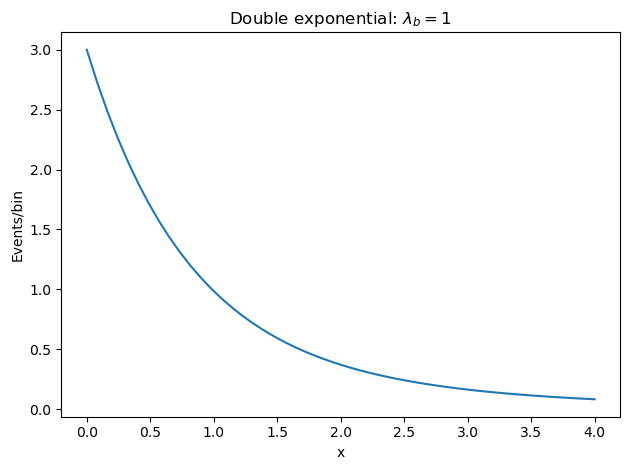

In [85]:
# fit
popt, pcov = curve_fit(exp2,x,y,p0=(1.0,1.0,1.0,1.0))

print(popt) # This contains best fit parameters

p1 = popt[0] # This is your a
p2 = popt[1] # This is your b
p3 = popt[2] # This is your c
p4 = popt[3] # This is your d
yfit = exp2(x,p1,p2,p3,p4)
residuals = y - yfit
chi2 = sum( (residuals**2)/yfit ) # The chi-sqaure of your fit

print(f"chi2 of fit = {chi2:.2f}")

[0.5 0.5 2.5 1.3]
chi2 of fit = 0.00


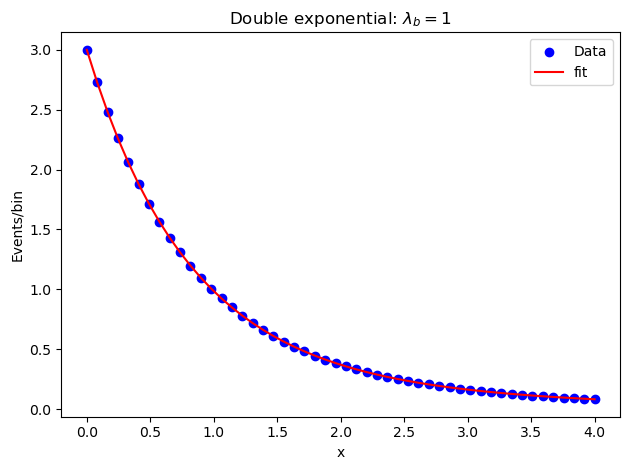

In [86]:
fig, ax = plt.subplots()

ax.scatter(x,y, c='b',label='Data')
ax.plot(x, yfit, 'red', label='fit')
ax.set_xlabel('x')
ax.set_ylabel('Events/bin')
ax.set_title('Double exponential: '
             fr'$\lambda_b={b:.0f}$')
plt.legend(loc='best')
fig.tight_layout()
plt.show()

In [105]:
df = pd.read_csv('AAN155_1E-5M.csv', sep=';', header=0,  decimal=',')

In [106]:
df

,time,AAN155Free,AAN155_Ba,solvent
0,0.000000,0.0,0.0,0.0
1,2.441406,0.0,0.0,0.0
2,4.882812,0.0,0.0,0.0
3,7.324219,0.0,0.0,0.0
4,9.765625,0.0,0.0,0.0
...,...,...,...,...
4091,9987.793000,12.0,22.0,3.0
4092,9990.234400,7.0,31.0,0.0
4093,9992.675800,8.0,23.0,4.0
4094,9995.117200,8.0,25.0,3.0


In [94]:
dfnames = df.columns

In [109]:
print(dfnames[1], dfnames[2])

AAN155Free AAN155_Ba


In [112]:
len(df.time.values)

4096

In [127]:
def plot_df_data(df):
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(df.time.values,df.AAN155Free.values, c='b',label=f'{dfnames[1]}')
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('I (a.u.)')
    ax[0].legend(loc='best')
    ax[1].plot(df.time.values,df.AAN155_Ba.values, c='r',label=f'{dfnames[2]}')
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('I (a.u.)')
    
    ax[1].legend(loc='best')
    fig.tight_layout()
    plt.show()


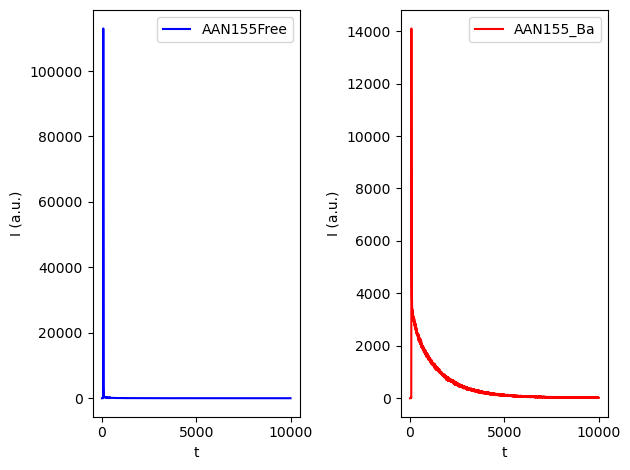

In [128]:
plot_df_data(df)

In [305]:
df2 = df.iloc[100:-1]

In [306]:
df2

,time,AAN155Free,AAN155_Ba,solvent
100,244.14063,255.0,2850.0,6.0
101,246.58200,242.0,2930.0,1.0
102,249.02344,231.0,2860.0,2.0
103,251.46484,235.0,2820.0,7.0
104,253.90625,272.0,2800.0,2.0
...,...,...,...,...
4090,9985.35160,14.0,25.0,3.0
4091,9987.79300,12.0,22.0,3.0
4092,9990.23440,7.0,31.0,0.0
4093,9992.67580,8.0,23.0,4.0


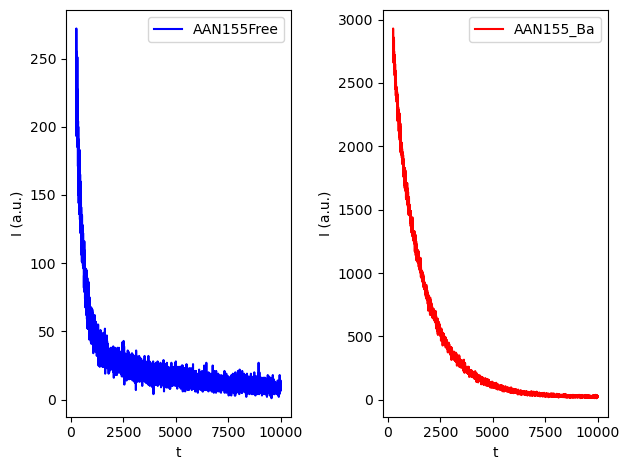

In [307]:
plot_df_data(df2)

In [308]:
# Define the number of bins

def profile(x,y,num_bins = 50): 
    # Create bins and calculate mean and standard deviation in each bin
    bins = np.linspace(x.min(), x.max(), num_bins+1)
    indices = np.digitize(x, bins)
    bin_means = [y[indices == i].mean() for i in range(1, len(bins))]
    bin_stds = [y[indices == i].std() for i in range(1, len(bins))]

    # Mid-points of bins for plotting
    bin_mids = (bins[:-1] + bins[1:]) / 2
    return bin_mids, bin_means, bin_stds



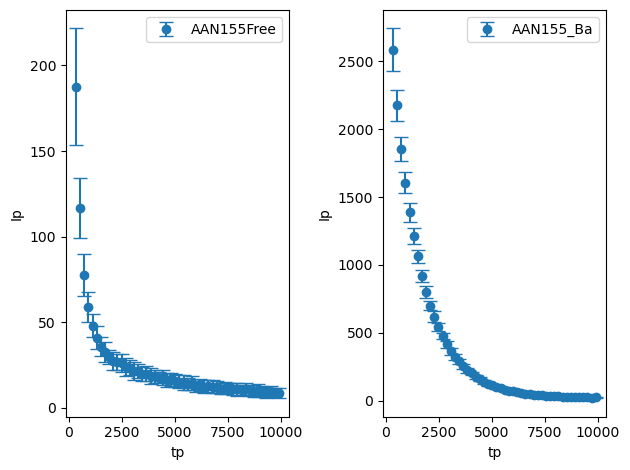

In [309]:
xp,yp,stds = profile(df2.time.values,df2.AAN155Free.values ,num_bins = 50)
xpb,ypb,stdb = profile(df2.time.values,df2.AAN155_Ba.values ,num_bins = 50)
    

fig, ax = plt.subplots(1,2)
ax[0].errorbar(xp, yp, yerr=stds, fmt='o', capsize=5, label=f'{dfnames[1]}')
ax[0].set_xlabel('tp')
ax[0].set_ylabel('Ip')
ax[0].legend(loc='best')

ax[1].errorbar(xpb, ypb, yerr=stdb, fmt='o', capsize=5, label=f'{dfnames[2]}')
ax[1].set_xlabel('tp')
ax[1].set_ylabel('Ip')
ax[1].legend(loc='best')
fig.tight_layout()
plt.show()

In [310]:
def double_exponential(x, a, b, c, d, e):
    return a * np.exp(-x/b) + c * np.exp(-x/d) + e
    

In [311]:
def fit_exp2(x, y, p0=(1e+3,1e+3,1e+3,1e+3, 1e+2 )):
    
    params, params_covariance = curve_fit(double_exponential, x, y, p0=p0)
    yfit = double_exponential(x, *params)
    residuals = y - yfit
    chi2 = sum( (residuals**2)/y ) # The chi-sqaure of your fit
    return params, yfit, chi2



In [312]:
parb, yftb, chi2b = fit_exp2(xpb,ypb, p0=(1e+3,1e+3,1e+3,1e+3, 1e+2))
print(f"fit par: a = {parb[0]:.2f}, b = {parb[1]:.2f}")
print(f"fit par: c = {parb[2]:.2f}, d = {parb[3]:.2f}, e = {parb[4]:.2f}")
print(f"chi2 of fit = {chi2b:.2f}")

fit par: a = 764.21, b = 278.84
fit par: c = 2970.69, d = 1427.84, e = 22.47
chi2 of fit = 1.71


In [313]:
parf, yftf, chi2f = fit_exp2(xp,yp, p0=(1e+3,1e+3,1e+3,1e+3, 1e+2))
print(f"fit par: a = {parf[0]:.2f}, b = {parf[1]:.2f}")
print(f"fit par: c = {parf[2]:.2f}, d = {parf[3]:.2f}, e = {parf[4]:.2f}")
print(f"chi2 of fit = {chi2f:.2f}")

fit par: a = 41.07, b = 2961.39
fit par: c = 444.44, d = 300.96, e = 7.99
chi2 of fit = 0.71


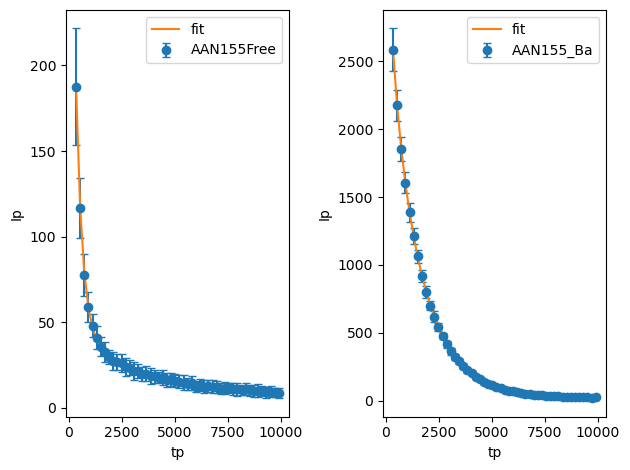

In [314]:
fig, ax = plt.subplots(1,2)
ax[0].errorbar(xp, yp, yerr=stds, fmt='o', capsize=3, label=f'{dfnames[1]}')
ax[0].plot(xp, yftf, label="fit")
ax[0].set_xlabel('tp')
ax[0].set_ylabel('Ip')
ax[0].legend(loc='best')

ax[1].errorbar(xpb, ypb, yerr=stdb, fmt='o', capsize=3, label=f'{dfnames[2]}')
ax[1].plot(xpb, yftb, label="fit")
ax[1].set_xlabel('tp')
ax[1].set_ylabel('Ip')
ax[1].legend(loc='best')
fig.tight_layout()
plt.show()

In [329]:
def norm2exp(pars):
    a = pars[0]
    b = pars[1]
    c = pars[2] 
    d = pars[3] 
    e = pars[4]
    return a/(a+c+e), b, c/(a+c+e), d, e/(a+c+e)
    

In [331]:
i1f, l1f, i2f, l2f, ef = norm2exp(parf)
print(f'Ann Free')
print(f'Intensity of exponential 1 = {i1f:.4f}, lifetime = {l1f:.4f} ns') 
print(f'Intensity of exponential 2 = {i2f:.4f}, lifetime = {l2f:.4f} ns') 
print(f'Intensity of constant term = {ef:.4f}') 

Ann Free
Intensity of exponential 1 = 0.0832, lifetime = 2961.3950 ns
Intensity of exponential 2 = 0.9006, lifetime = 300.9648 ns
Intensity of constant term = 0.0162


In [332]:
i1b, l1b, i2b, l2b, eb = norm2exp(parb)
print(f'Ann Ba2+')
print(f'Intensity of exponential 1 = {i1b:.4f}, lifetime = {l1b:.4f} ns') 
print(f'Intensity of exponential 2 = {i2b:.4f}, lifetime = {l2b:.4f} ns') 
print(f'Intensity of constant term = {eb:.4f}') 

Ann Ba2+
Intensity of exponential 1 = 0.2034, lifetime = 278.8370 ns
Intensity of exponential 2 = 0.7906, lifetime = 1427.8420 ns
Intensity of constant term = 0.0060


In [334]:
30/np.pi

9.549296585513721

In [336]:
18 * 530 + 1000 + 320

10860

In [339]:
def nc(dmm, Lmm):
    return np.floor(np.pi * dmm/50), np.floor(Lmm/50)  

In [343]:
np.prod(nc(700, 1000)) * 500/1e+5

4.3

In [352]:
clyso = 45 # $/cm3

In [353]:
vcm = 5 * 5 * 2.2

In [354]:
cclyso = clyso * vcm

In [355]:
print(f"cost lyso crystal 50 x 50 x 2X0 = {cclyso:.2f}")

cost lyso crystal 50 x 50 x 2X0 = 2475.00


In [360]:
sipm = 15 #$ --> 3 x 3

In [361]:
s3x3c = 16*16 * sipm

In [362]:
s3x3c

3840

In [367]:
s6x6c = 8*8 * 30

In [368]:
s6x6c

1920

In [369]:
asic = 8*8*10

In [370]:
asic

640

In [372]:
np.prod(nc(700, 1000)) * asic/1e+6

0.5504

In [373]:
np.prod(nc(700, 1000)) * s6x6c/1e+6

1.6512

In [374]:
np.prod(nc(700, 1000)) * s3x3c/1e+6

3.3024

In [375]:
np.prod(nc(700, 1000)) * s3x3c/1e+6 + np.prod(nc(700, 1000)) * asic/1e+6 + np.prod(nc(700, 1000)) * 2450/1e+6

5.9598